In [2]:
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch

In [5]:
group_1 = [
    'vk_2_eg', 'stahl_folder', 'r707lv_f4032', 
    'r707lv_f4034', 'r707lv_vari_air', 'og_3'
]

### Kernel Composition

**Note**: Normalization of time range effects the period length hyperparams.
 - Solution? Normalize the range of period constraints

In [8]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.06, 0.12) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.16, 0.22) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module = locally_short_periodic + locally_long_periodic + local_variation

In [6]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess('r707lv_f4032_30T', 30, True)

Iter 1 , Loss = 1.2794751437979794 , Noise = 0.6932471990585327
Iter 2 , Loss = 1.2503292306433984 , Noise = 0.6444966793060303
Iter 3 , Loss = 1.2308205059828377 , Noise = 0.5981784462928772
Iter 4 , Loss = 1.2080973092184684 , Noise = 0.5543985962867737
Iter 5 , Loss = 1.1836111021840043 , Noise = 0.5131590962409973
Iter 6 , Loss = 1.1633076291316042 , Noise = 0.4744205176830292
Iter 7 , Loss = 1.1489070811819413 , Noise = 0.4383544623851776
Iter 8 , Loss = 1.137821414523664 , Noise = 0.40544164180755615
Iter 9 , Loss = 1.127868130262953 , Noise = 0.37629756331443787
Iter 10 , Loss = 1.118171980851946 , Noise = 0.3513631820678711
Iter 11 , Loss = 1.108877027808534 , Noise = 0.3307049870491028
Iter 12 , Loss = 1.1006838110885602 , Noise = 0.3140909969806671
Iter 13 , Loss = 1.0938746106664707 , Noise = 0.3012368381023407
Iter 14 , Loss = 1.088694381245823 , Noise = 0.2918778359889984
Iter 15 , Loss = 1.0855390067433222 , Noise = 0.28569066524505615
Iter 16 , Loss = 1.0846175014289114 

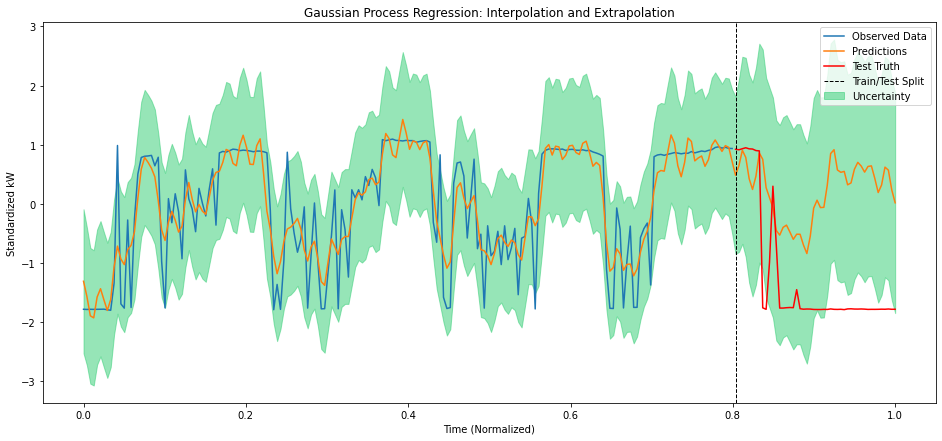

In [9]:
model, likelihood, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    time_agg='30T',
    machine='r707lv_f4032',
    update_score=True
)   